In [1]:
import ast
import os
import re
import unicodedata

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from ckiptagger import (
    data_utils, construct_dictionary, 
    WS, POS, NER
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy

pd.set_option('display.max_colwidth', -1)

%matplotlib inline

/home/bird/Documents/Code/tbrain20_AML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bird/Documents/Code/tbrain20_AML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bird/Documents/Code/tbrain20_AML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bird/Document

In [2]:
data_path = "data/tbrain_train_final_0610.csv"

df = pd.read_csv(data_path)
df.head()

,news_ID,hyperlink,content,name
0,1,https://news.cnyes.com/news/id/4352432,0理財基金量化交易追求絕對報酬有效對抗牛熊市鉅亨網記者鄭心芸2019/07/05 22:35facebook commentFONT SIZEICON PRINT78981DD6-B6FA-435C-B969-0D6ABD01805C0「時間序列與量化交易研討會」邀集專家學者進行量化交易、智能投資等相關議題研討。(圖:鄭心芸攝)相關個股元大期6023近年來投資市場波動越來越明顯 ### 省略內文 ### 都有非常巨大的助益。,[]
1,2,https://udn.com/news/story/120775/4112519,10月13日晚間發生Uber Eats黃姓外送人員職災死亡案件 ### 省略內文 ### 北市政府今日下午也跨局處召開「外送人員保障專案會議」。圖／台北市勞動局提供,[]
2,3,https://www.mirrormedia.mg/story/20191008soc011/,2019.10.08 01:53【法拍有詭4】飯店遭管委會斷水斷電員工怒吼：生計何去何從？文｜李育材攝影｜李育材全文朗讀00:00 / 00:00君鴻飯店快速遭法拍 ### 省略內文 ### 亦即本次拍賣事件均屬合法。更新時間｜2019.10.10 09:14,[]
3,4,https://www.chinatimes.com/realtimenews/20190917000619-260106,58歲林姓男子昨凌晨與朋友聚餐結束後 ### 省略內文 ### 而地點就距離林家僅30公尺。 (中國時報),[]
4,5,http://domestic.judicial.gov.tw/abbs/wkw/WHD9HN03.jsp?crtid=PTD&filenm=ECE5DAECAF563DA171E34B03FC5185742FC90F879191D5DF,例稿名稱：臺灣屏東地方法院公示催告公告發文日期：中華民國108年9月20日發文字號：屏院進家親108年度司家催字第58號附件：主旨：公告本院108年度司家催字第58號公示催告事件裁定。依據：家事事件法第137條、第138條、第139條準用第130條第3項至第5項、臺灣地區及大陸地區人民關係條例第68條第1項、第3項、退除役官兵死亡無人繼承遺產管理辦法第6條。公告事項：一、本案遺產管理人為國軍退除役官兵輔導委員會屏東榮譽國民之家（住址：屏東縣內埔鄉○○路000號）。二、本件係對被繼承人陳世恒（男、民國16年10月6日生、身分證統一編號：F10****885號、108年8月29日死亡、生前最後住所地：屏東縣內埔鄉○○路000號）之繼承人、債權人及受遺贈人為公示催告。三、被繼承人陳世恒之繼承人（除大陸地區人民應依臺灣地區與大陸地區人民關係條例之規定外）、債權人及受遺贈人 ### 省略內文 ### 僅得就賸餘遺產行使其權利。五、本件裁定正本黏貼於本院公告處。核章欄：書記官科長司法事務官書記官：沈君融股別：親,[]


## Get crawled files

In [3]:
DIR_PATH = os.path.abspath(
    f"./data/news"
)
FILES = sorted(os.listdir(DIR_PATH))
FILES.sort(key=len, reverse=False)

FILES = [f"{DIR_PATH}/{path}" for path in FILES]

corpus = []

for p in FILES:
    with open(p, "r") as f:
        corpus.append(f.readline())

In [4]:
print(f"Max Document Length: {max([len(c) for c in corpus])}")

Max Document Length: 5538


In [5]:
u_name = df["name"].tolist()
merged = zip(corpus, u_name)

## Get all names

In [6]:
name_list = df["name"].tolist()
name_list = [ast.literal_eval(name) for name in name_list]
print(f"Max Number of Names: {max([len(ns) for ns in name_list])}")

x = {idx: ns for idx, ns in enumerate(name_list) if len(ns) == 0}
print(f"Number of documents without label: {len(x)}")

Max Number of Names: 15
Number of documents without label: 4651


In [7]:
unique_names = list({n for name in name_list for n in name})
print(f"The number of unique names: {len(unique_names)}")
print(unique_names)

The number of unique names: 830
['楊仕豪', '許道德', '黃昱凱', '陳威廷', '林霙璋', '李俊琳', '柯賜海', '林宏柏', '余世彰', '廖麗櫻', '李春生', '吳志麒', '李建邦', '彭達明', '薛義雄', '王懷恭', '劉慶珠', '余豪', '林茂榮', '楊士弘', '蔣楚明', '黃哲修', '蘇芸樂', '王桂霜', '朱傑麟', '張建華', '李維凱', '周長輝', '焦名薇', '程國忠', '陳文宏', '陳粹鑾', '陳國楨', '傅春生', '陳水扁', '黃弘毅', '於勇明', '何育仁', '戴家秀', '林政賢', '曾杭皆', '陳中光', '謝明陽', '林健標', '鄭銘坤', '張桂銘', '楊明達', '黃子窈', '黃奕霖', '郭明賓', '黃林麗玉', '廖泰宇', '阮氏秋雲', '劉尊彰', '陳榮元', '陳耀東', '邱世忠', '陳榮祥', '林耿宏', '楊宇晨', '齊德清', '王紀棠', '顏志峰', '陳孝仁', '張鳳桂', 'Sreenack', '詹昭書', '李大彰', '陳志銘', '詹雅琳', '邱希庚', '陳瑞芳', '周陳文彬', '林聖凱', '賴進坤', '簡志霖', '陳進村', '詹博翔', '邱春茂', '陳世坤', '何歡', '陳玉瑛', '黃春發', '徐正倫', '常偉政', '紀雅玲', '李克毅', '黃子愛', '吳運豐', '楊強蓉', '林明忠', '王羿雄', '裘振儀', '黃鈺蘋', '鄒官羽', '孔朝', '余依珊', '許文豪', '洪博文', '趙玉柱', '林睿耆', '劉明冠', '吳思遠', '葉鯤璟', '林豪', '吳麗玲', '張建生', '謝世謙', '李欣潔', '郭明枝', '童仲彥', '徐仲榮', '王宇正', '呂宗南', '于求潭', '柯路加', '曾敬恆', '洪正義', '林輝宏', '蕭錦戎', '賴文德', '黃馨儀', '王禹婕', '王炳漢', '陳鏡如', '黃建彰', '張淑晶', '鄒雪娥', '何煖軒', '劉奕發', '賴麗團', '吳佳駿', '楊昇穎', '黃睿靚', '楊永昌', '許正雄', '陳發貴', '張永泉

## Merge crawled with labels

In [8]:
final_df = pd.DataFrame(
    {
        'corpus' : corpus,
        'labels' : u_name
    }
)

In [9]:
final_df.head()

,corpus,labels
0,"近年來投資市場波動越來越明顯,追求低波動、絕對報酬的量化交易備受注目。專家表示,採用量化交易策略投資台股,不管是處於多頭或是空頭市場,績效及波動度均可領跑大盤,甚至比國內投資台股的股票型基金及 ETF 的波動率還低,表現也更為穩定。\n",[]
1,"10月13日晚間發生Uber Eats黃姓外送人員職災死亡案件,北市府勞動局認定業者未依職業安全衛生法第37條第2項第1款規定於8小時內向勞動檢查機構通報,開罰Uber Eats 30萬元。\n",[]
2,"君鴻酒店業者控訴高雄地院強制法拍龐大資產,是為了讓財團得利。君鴻業主表示,拍得君鴻的凱德唐公司要求85大樓管委會,在今年8月21日晚上11點後,將酒店斷水斷電,還讓電梯、緊急升降梯停擺,甚至將緊急逃生門鎖死,無視君鴻酒店於點交前仍可合法使用,還有損仍在大樓內辦公,且不點交的福勵、樂活、富勝3家公司員工權益,導致員工無法上班,客戶無法進入,以致公司經營困難、損失巨大。這3家公司緊急反應給高雄地院執行處,沒想到高雄地院竟回覆這些事項非該處所得置問,叫可憐員工情何以堪?\n",[]
3,\n,[]
4,"主旨:公告本院108年度司家催字第58號公示催告事件裁定。 一、本案遺產管理人為國軍退除役官兵輔導委員會屏東榮譽國 三、被繼承人陳世恒之繼承人(除大陸地區人民應依臺灣地區 四、繼承人不於上述期間內承認繼承,於清償債權並交付遺贈 如欲查詢上開公告之裁定,請逕至本院「裁判書查詢」網頁查詢。 對公告內容有疑義者,請逕向承辦法院書記官洽詢,或電洽司法院。\n",[]


## TFIDF Visualization

In [10]:
def tfidf_embeddings(sentences):
    tfidf = TfidfVectorizer(use_idf=True)
    tfidf_score = tfidf.fit_transform(sentences)
    vocabulary = tfidf.vocabulary_
    vectors = tfidf_score.toarray()
    return vocabulary, vectors

In [11]:
vocab, vec = tfidf_embeddings(corpus)

In [12]:
label = [1 if len(names) > 1 else 0 for names in name_list]

In [13]:
pca_res = PCA().fit_transform(vec)[:,:2]
df_res = pd.DataFrame()
df_res['pca-2d-one'] = pca_res[:,0]
df_res['pca-2d-two'] = pca_res[:,1]
df_res['label'] = label

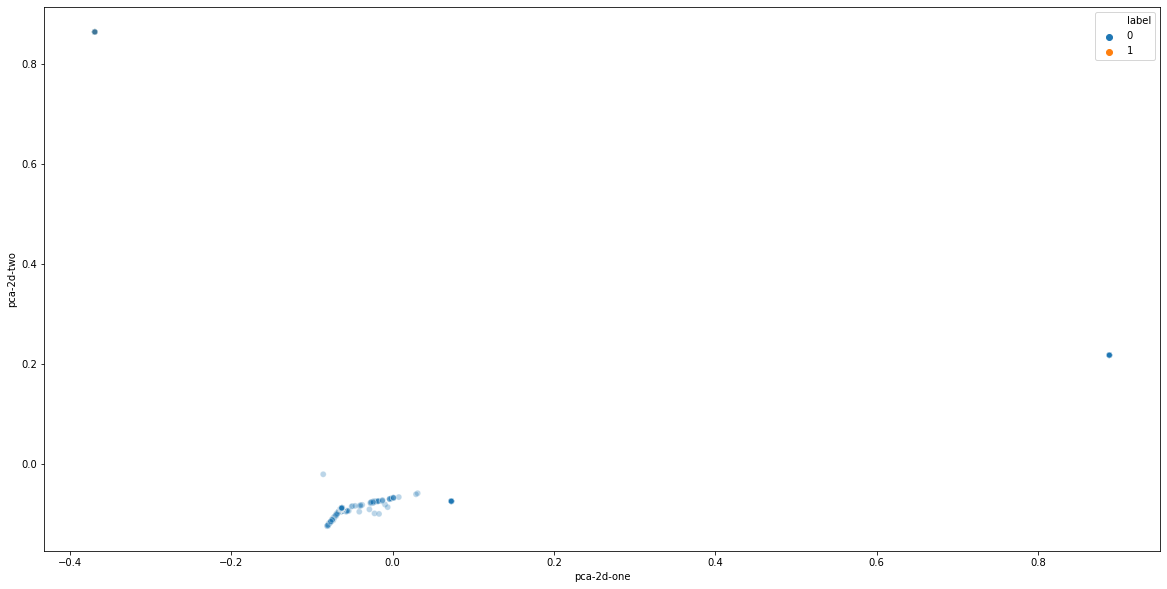

In [14]:
plt.figure(figsize=(20,10))
sns.scatterplot(
    x="pca-2d-one", y="pca-2d-two",
    hue='label',
    # palette=color,
    data=df_res,
    legend="full",
    alpha=0.3
)

## SpaCy Encoder Visualization

In [15]:
nlp = spacy.load("zh_core_web_lg")
spacy_processed = []
for sentence in corpus:
    spacy_processed.append(nlp(sentence).vector)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.439 seconds.
Prefix dict has been built successfully.


In [16]:
pca_res = PCA().fit_transform(spacy_processed)[:,:2]
df_res = pd.DataFrame()
df_res['pca-2d-one'] = pca_res[:,0]
df_res['pca-2d-two'] = pca_res[:,1]
df_res['label'] = label

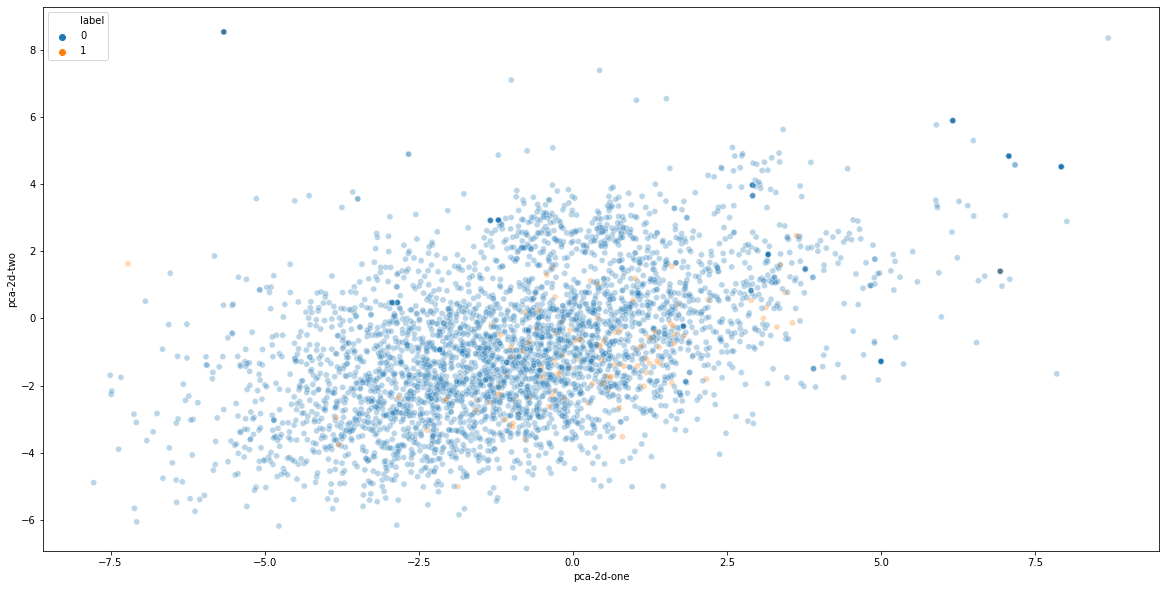

In [17]:
plt.figure(figsize=(20,10))
sns.scatterplot(
    x="pca-2d-one", y="pca-2d-two",
    hue='label',
    # palette=color,
    data=df_res,
    legend="full",
    alpha=0.3
)